<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/Alex_HershUnit8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart
import pymc_bart as pmb
#!pip install preliz

# GOP/POP and Suicide Rates

I'm going to further analyze the connection between suicide rates and percentage GOP. I'll look to see if the connection could plausibly be explained by GOP's connection with population, and, if not, I'll look for other factors that may cause a relationship between gop/pop and suicide rates.

## Assumptions

I'm going to keep my assumptions to a minimum. I'm assuming that I have enough data to run BART without overfitting, but I won't assume much more than that.

Data for suicides in a county is unavaible for counties with less than 10 suicides, so I'm going to assume this won't invalidate any BART model. I will take this into consideration in further discussions though.

I'm also assuming that suicide rate can be modelled by a gamma (I'll explain this more later) and that my priors are right.

# Priors and Likelihood

I'm going to use a BART model to predict the rate of suicides (suicides / population) in a county. I'm then going to plug this into a gamma distribution for the likelihood.

The amount of times a certain event occurs (such as suicides) in a given time frame is a Poisson or gamma distribution. Dividing by population (to get suicides / population, or sui_rate) won't change the distribution for each observation, so suicide rates should follow a gamma distribution.

My prior for the variance of the gamma distribution will be a HalfNormal. I really have no clue what the variance of the gamma distribution should be, so I'll express this in a half normal. The sigma will be .0003, above the actual variance of suicide rate

# Data

In [3]:
counties = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/counties.csv')

In [4]:
for col in counties.columns:
  print(col)

name
fips
state
land_area (km^2)
area (km^2)
longitude (deg)
latitude (deg)
noaa/prcp
noaa/snow
noaa/temp
noaa/altitude
noaa/temp-jan
noaa/temp-apr
noaa/temp-jul
noaa/temp-oct
zip-codes
race/non_hispanic_white_alone_male
race/non_hispanic_white_alone_female
race/black_alone_male
race/black_alone_female
race/asian_alone_male
race/asian_alone_female
race/hispanic_male
race/hispanic_female
age/0-4
age/5-9
age/10-14
age/15-19
age/20-24
age/25-29
age/30-34
age/35-39
age/40-44
age/45-49
age/50-54
age/55-59
age/60-64
age/65-69
age/70-74
age/75-79
age/80-84
age/85+
male
female
population/2010
population/2011
population/2012
population/2013
population/2014
population/2015
population/2016
population/2017
population/2018
population/2019
deaths/suicides
deaths/firearm suicides
deaths/homicides
deaths/vehicle
bls/2004/labor_force
bls/2004/employed
bls/2004/unemployed
bls/2008/labor_force
bls/2008/employed
bls/2008/unemployed
bls/2012/labor_force
bls/2012/employed
bls/2012/unemployed
bls/2016/labor_

I'm first going to look at the relationship between gop/pop and population. Lower populations typically have a higher gop/pop and the relationship between gop/pop and suicide rate could be because of population differences.

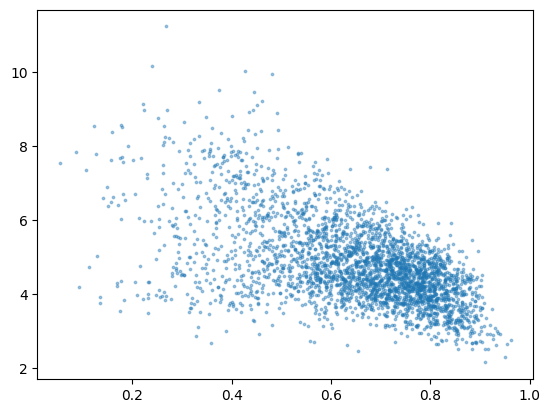

In [5]:
gopPop2020 = counties['elections/2020/gop']/counties['elections/2020/total'] # this is slightly different than the formula done in the notes. It's percent of those who voted that voted republican rather than percent of population that voted gop.
pop2019 = counties['population/2019']
plt.scatter(gopPop2020,np.array(pop2019)**.15, alpha=.4, s=3) # Scaling population down so the graph is viewable. Higher populations are still higher.

Gtaph above is population vs gop/pop.

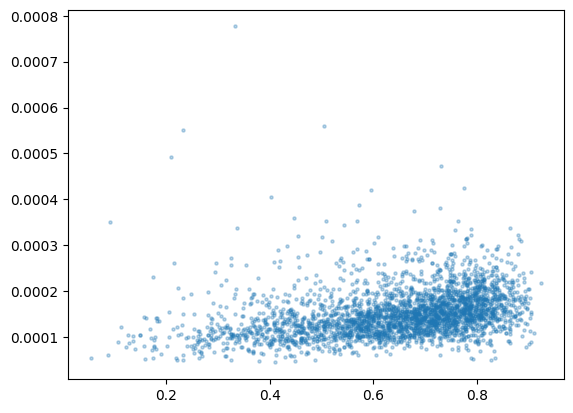

In [6]:
sui_rate = counties['deaths/suicides']/pop2019
plt.scatter(gopPop2020,sui_rate, alpha=.3,s=5)

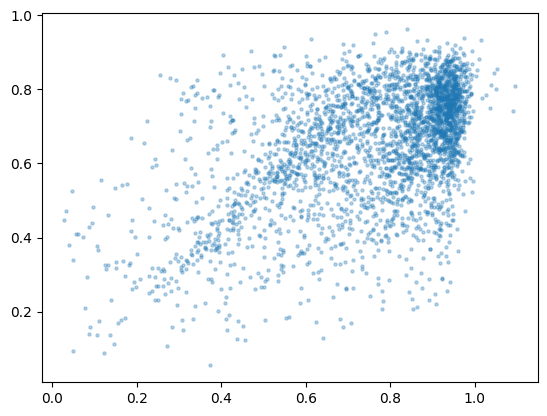

In [7]:
plt.scatter(counties['race/non_hispanic_white_alone_male'] + counties['race/non_hispanic_white_alone_male'],gopPop2020, alpha=.3, s=5)

Top graph is sui_rate vs gop/pop and second graph is sui_rate vs population. Sui_rate is always on the y axis.

There does seem to be a relationship between sui_rate and gop/pop. They both look like they could be rather significant.

The curve at the bottom right of the bottom graph is also rather significant. The curve is there because certain populations have no suicide rates below a certain value. Only counties with more than 10 suicides have suicide data recorded, so the cause of this curve isn't a trend in the data but a problem with data collection. This will most likely make the results look more significant than they are.

Population is on the y-axis and gop/pop is on the x-axis.

There is a significant relationship between gop/pop and population. It looks rather linear after the transformation. If there is a significant relathionship between population and suicide rate, than the relationship between gop/pop and suicide rate *may* be able to be explained by smaller populations having higher suicide rates.

# Models

I am first going to run a few models with gop/pop, population, and suicide rate. If the reason for gop/pop having a relationship with suicide rate is because of their collective relationship with population, it should show in a model using all three variables.

In [8]:
counties.insert(counties.shape[1], "gopPop2020", gopPop2020)
counties.insert(counties.shape[1], "pop2019", pop2019)
counties.insert(counties.shape[1], "sui_rate", sui_rate)

In [12]:
counties = counties.dropna(subset=['gopPop2020', 'sui_rate', 'pop2019', 'deaths/firearm suicides']) # This is missing values in the data I am using. The model will have problems running without doing this.

Below is condensed code to run a model. It is predicting sui_rate with gop/pop. I'll run two more models like this using population as a predictor and population and gop/pop together as predictors. The first model is my first DAG, just suicide rate and gop/pop, and the third model is the second on my DAG: suicide rate, gop/pop, and population all affecting each other in weird ways.

Output()

Output()

<Axes: ylabel='R²'>

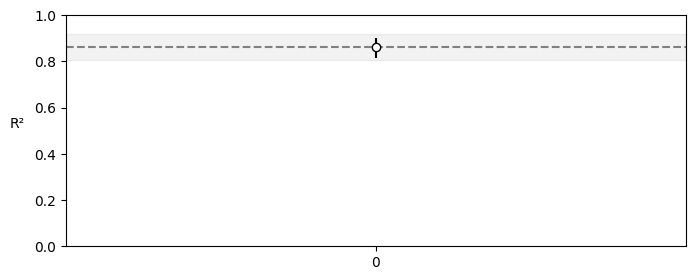

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["gopPop2020"]
X = counties[predictors].to_numpy()
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

Output()

Output()

<Axes: ylabel='R²'>

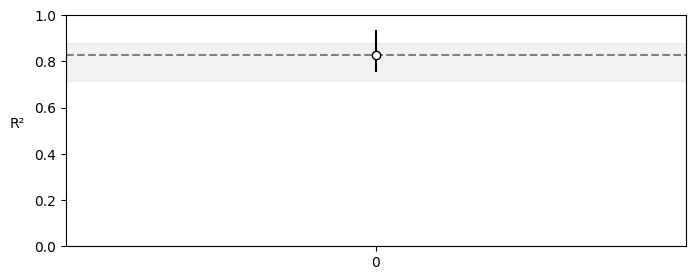

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["pop2019"]
X = counties[predictors].to_numpy()
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

Output()

Output()

<Axes: ylabel='R²'>

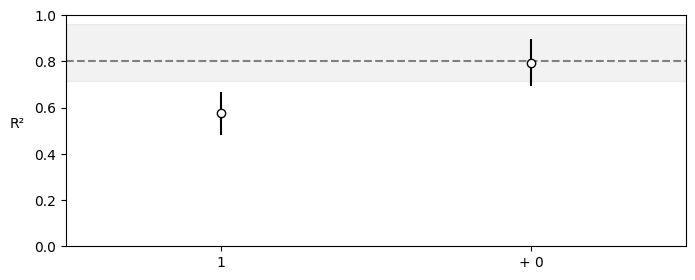

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["gopPop2020", "pop2019"]
X = counties[predictors].to_numpy()
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

The top model is gop/pop, the second is pop, and the last is both.

They all seem to do just as good as each other. They all have a strong relationship with sui_rate. In fact, the R^2 average is a bit higher than the 5 predictor model in the notes.

The last model has population and gop/pop both adding to the R^2 value. This means that both variables add information to the model that the other doesn't have to predict sui_rate. Therefore, while the relationship between gop/pop and population is strong, it can't be the sole cause of the relationship between gop/pop and sui_rate.

array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>], dtype=object)

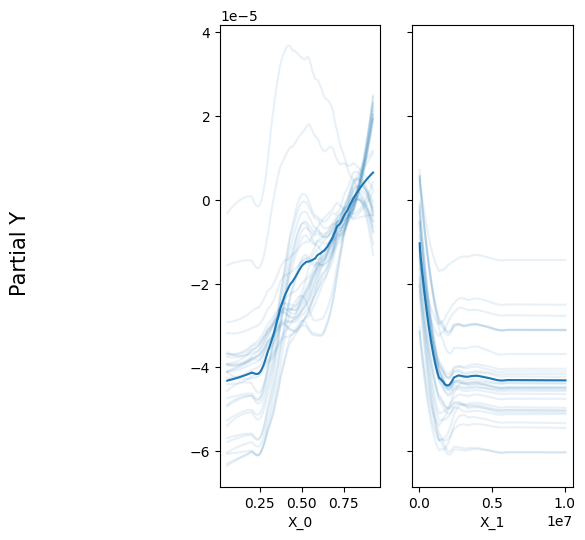

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

The above graph is the ice plot for gop/pop and population. Gop/pop is on the right and population is on the left.

 High values of population seem to have parallel predictions on the ice plot, but everything else shows signs of interaction. How gop/pop is related to suicide rate seems to depend heavily on population.

Interestingly, even though in the second model gop/pop is being heavily adjusted by population, the R^2 of both models has the same most likely value (.8). The second model should more accurately match the data, even if the model is overfitting, but it still has the same R^2 value. My best guess for why this is is that pymc bart takes the possibility of overfitting into account in the R^2 calculation.

# Looking into more variables

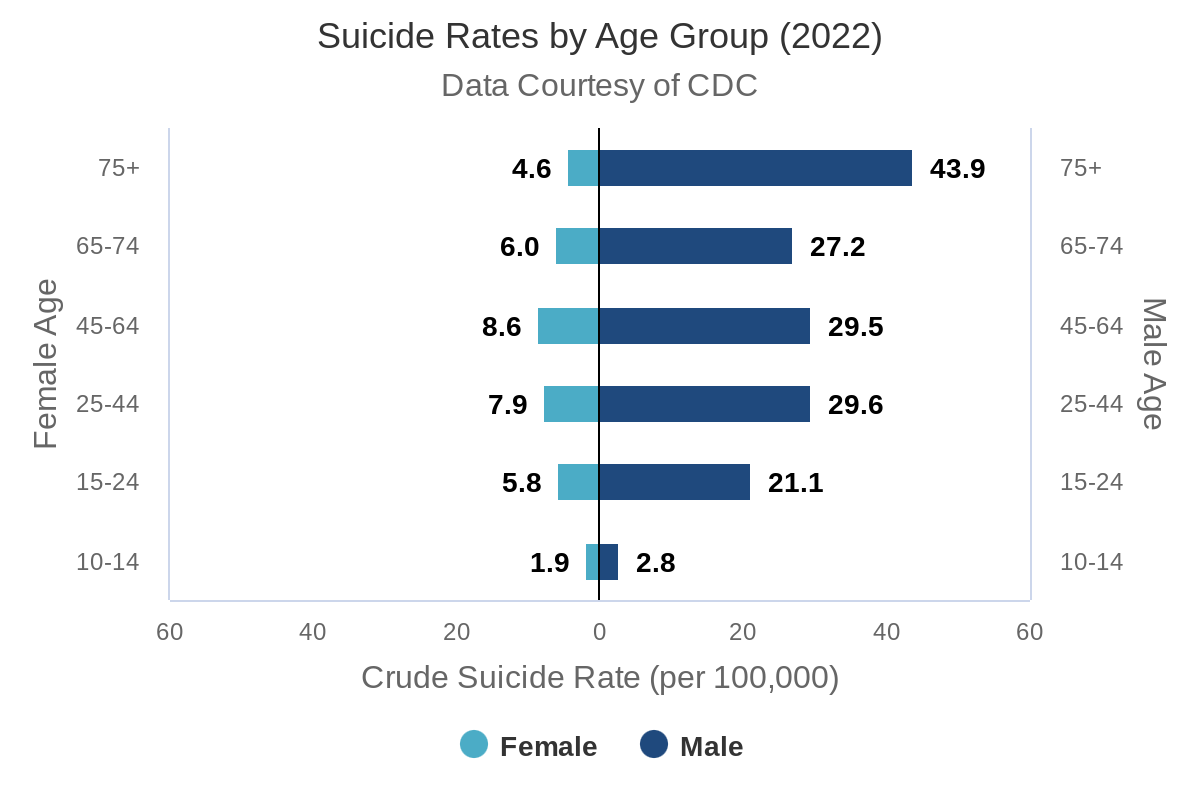

I'm going to look at the relationship between gender, age, gop/pop, and suicide rate next. As can be seen by the graph above, gender and age have quite a strong relationship with suicide rate. This model will correspond to my last DAG. I'm unsure about every single relation, so I just drew the DAG as everything connecting to everything. I can come up with a reasonable explanation for why any variable is related to another variable and can cause another. Since I'm not sure on the intensity of the relationships and BART doesn't need to know the form of the relationships, I did everything causes everything.

Just for example, a higher population can cause a more equal gender because people are having babies and evening the gender to 50-50. Or, more old people can cause a higher gop/pop because old people may be more likely to be Republican.

In [ ]:
counties.insert(counties.shape[1], "male_pop", counties.male/counties.pop2019)

In [ ]:
counties.insert(counties.shape[1], 'young', (counties['age/0-4'] + counties['age/5-9'] + counties['age/10-14'] + counties['age/15-19'] + counties['age/20-24']) / counties.pop2019)

In [ ]:
counties.insert(counties.shape[1], 'old', (counties['age/75-79'] + counties['age/80-84'] + counties['age/85+']) / counties.pop2019)

Output()

Output()

<Axes: ylabel='R²'>

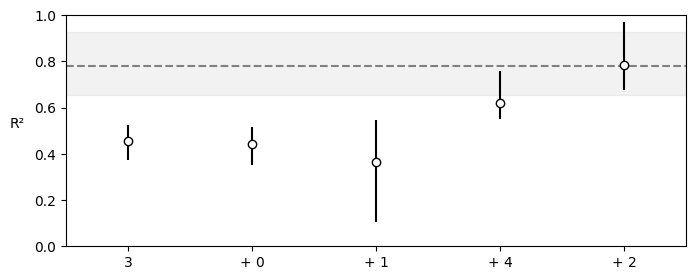

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["pop2019", "young", "gopPop2020", 'old', 'male']
X = counties[predictors].to_numpy()
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

<Axes: ylabel='R²'>

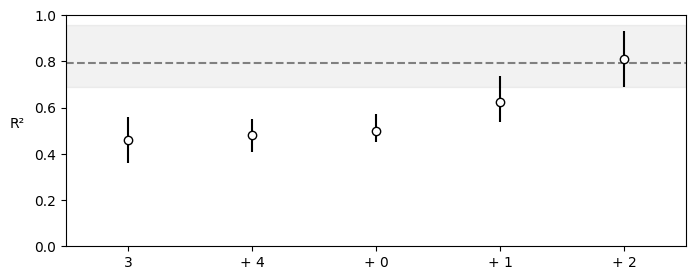

In [ ]:
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X, method="backward")
pmb.plot_variable_importance(vi_counties3) # this changes the order of when variables are added

As it turns out, neither age nor gender seem to improve the model or decrease the impact of gop/pop (gop/pop is +2 in the charts). Even though the national suicide rate is quite heavily impacted by gender and age, this connection at the county level doesn't seem too strong.

My best explanation for these new variables not being significant is that they are related to population. As can be seen in the second graph, adding population (+0) doesn't help the R^2 value. This indicates that age and population give roughly the same information relating to suicide rates.

I'm now going to run a bunch of models to see if they are significant. I won't make a DAG for any of them unless they come out significant. If I were to make a DAG, the vast majority would be undirected connections between all variables.

Output()

Output()

<Axes: ylabel='R²'>

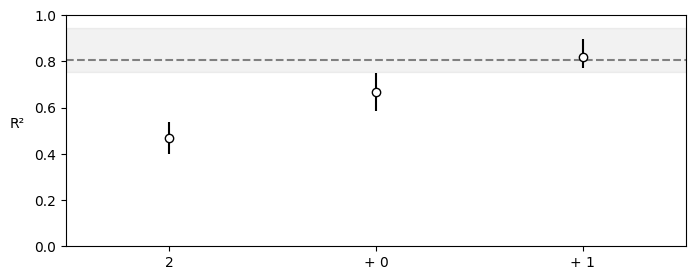

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["health/Average Number of Mentally Unhealthy Days", "gopPop2020", 'pop2019']
X = counties[predictors].to_numpy()
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

Output()

Output()

<Axes: ylabel='R²'>

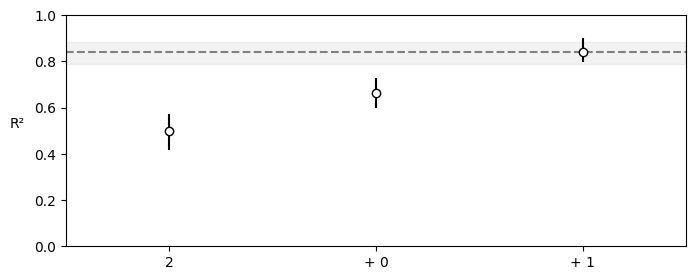

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["poverty-rate", "gopPop2020", 'pop2019']
X = counties[predictors].to_numpy()
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

Output()

Output()

<Axes: ylabel='R²'>

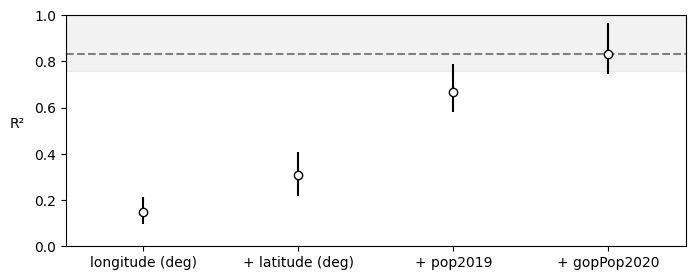

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["longitude (deg)", "latitude (deg)", "gopPop2020", 'pop2019']
X = counties[predictors]
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

Output()

Output()

<Axes: ylabel='R²'>

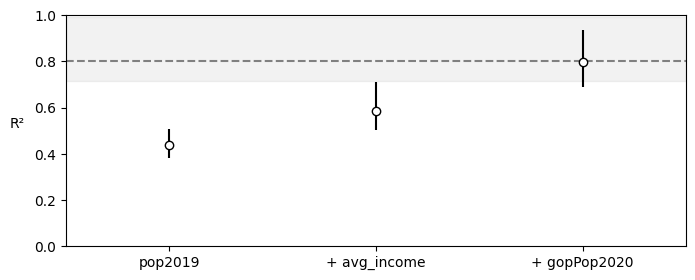

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["avg_income", "gopPop2020", 'pop2019']
X = counties[predictors]
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

Output()

Output()

<Axes: ylabel='R²'>

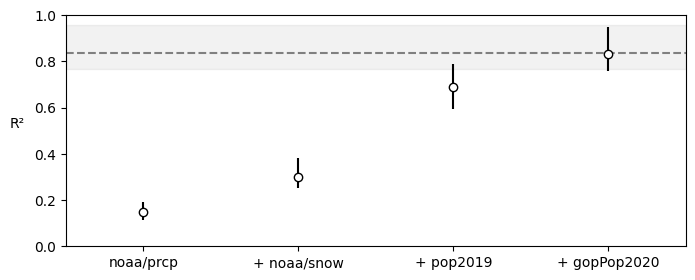

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ["noaa/prcp", 'noaa/snow', "gopPop2020", 'pop2019']
X = counties[predictors]
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

Output()

Output()

<Axes: ylabel='R²'>

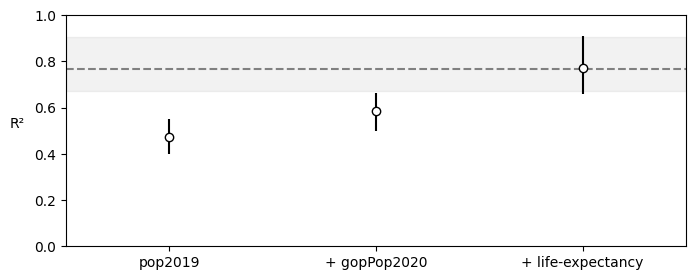

In [ ]:
y = counties.sui_rate; # I'm keeping the exponential transformation. It shouldn't matter too much with BART.
predictors = ['life-expectancy', "gopPop2020", 'pop2019']
X = counties[predictors]
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

<Axes: ylabel='R²'>

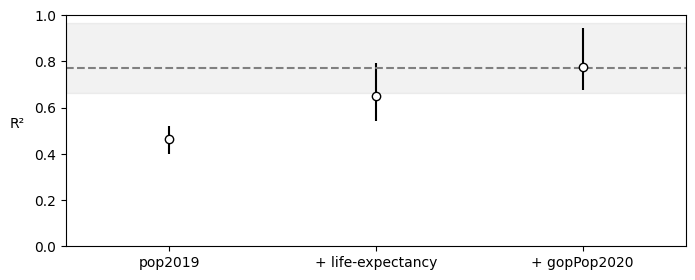

In [ ]:
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X, method="backward")
pmb.plot_variable_importance(vi_counties3)

Everything came out to .8 in the end. I couldn't find any variable in the dataset which improves upon just gop/pop.

# Conclusion

Gop/pop is the best predictor of suicide rates. According to pymc bart's R^2, adding other predictors doesn't improve upon the model.

As gop/pop increases, so does suicide rate.

A large part of gop/pop's relationship with suicide rates can be explained through population size. Larger populations have a lower gop/pop and lower suicide rate.

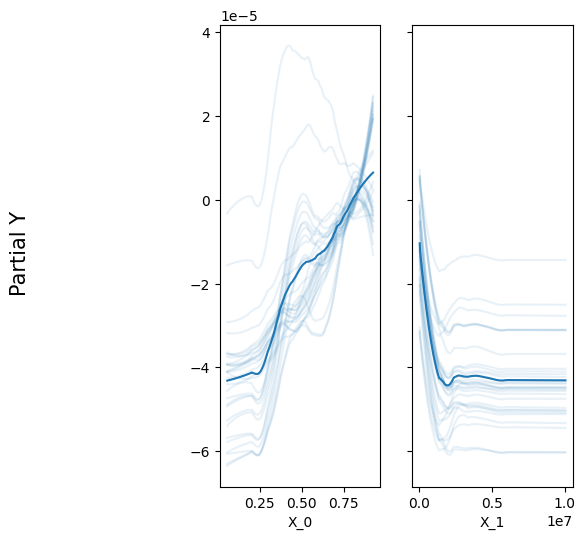

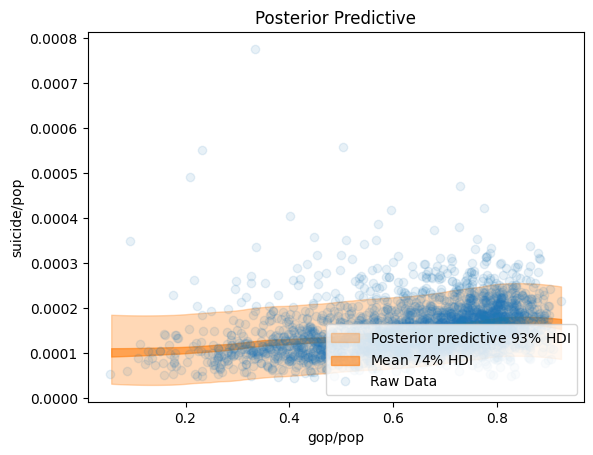

Even though adding in population changes the model, pymc concludes that the model isn't definitely better. Gop/pop by itself gives a good prediction and is simple enough with enough data to avoid overfitting. As far as I can tell, the consistent .8 R^2 means adding any variable to the model after gop/pop just makes the model overfit, not improve

A part of the reason population and gop/pop have such a significant relationtion with suicide rate is because of the dataset. Counties with less than 10 suicides didn't have their data released. Counties with low populations were affected more by this change because they were more likely to have less than 10 suicides. This artificially made small counties look like they had higher suicide rates.

The rest of the reason gop/pop and suicide is related either some other factor affecting both (like population) or explained by ideology. The most obvious link that I can see that couldn't be explored in this dataset is firearms.

# Extra

This kinda hurts after working on this for a bit, but I found the reason it's so significant.

Text(0, 0.5, 'Non-firearm suicide rate')

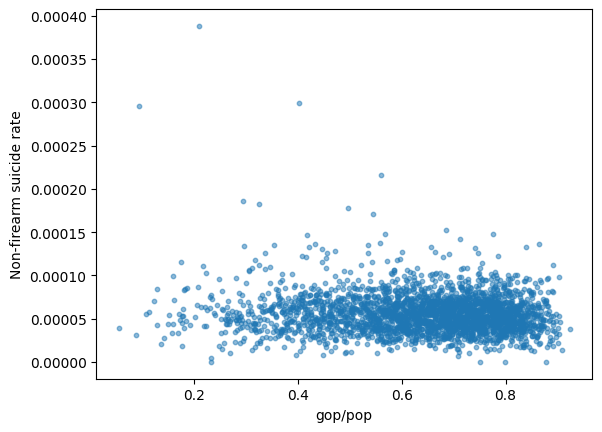

In [19]:
plt.scatter(counties['gopPop2020'], (counties['deaths/suicides']-counties['deaths/firearm suicides'])/counties['pop2019'], s=10, alpha=.5)
plt.xlabel("gop/pop")
plt.ylabel("Non-firearm suicide rate")

Output()

Output()

<Axes: ylabel='R²'>

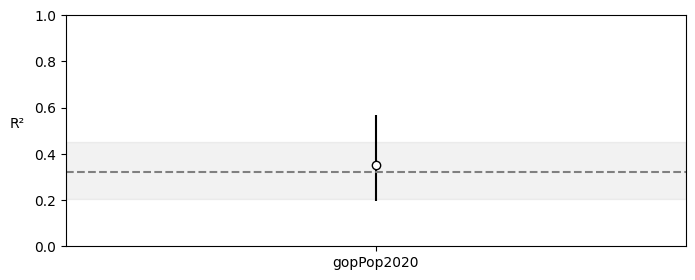

In [22]:
y = (counties['deaths/suicides']-counties['deaths/firearm suicides'])/(counties['pop2019'])+.0000001 # Adding so nothing is 0. Pymc doesn't like log 0.
predictors = ["gopPop2020"]
X = counties[predictors]
Y = y.to_numpy()
with pm.Model() as model_sui3:
    s = pm.HalfNormal('s',.0003) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_sui3 = pm.sample(compute_convergence_checks=False)
pm.sample_posterior_predictive(idata_sui3,model_sui3, extend_inferencedata=True)
vi_counties3 = pmb.compute_variable_importance(idata_sui3, μ_, X)
pmb.plot_variable_importance(vi_counties3)

I'll probably do next project on non-firearm suicides to make up for this